In [5]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the dataset path
data_dir = '/content/drive/MyDrive/My dataset'

# Function to filter invalid files
def filter_valid_images(directory):
    """Ensure only valid image files are included."""
    supported_formats = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    for root, _, files in os.walk(directory):
        for file in files:
            if not file.lower().endswith(supported_formats):
                print(f"Removing unsupported file: {os.path.join(root, file)}")
                os.remove(os.path.join(root, file))

# Filter invalid files in the dataset directory
filter_valid_images(data_dir)

# Verify dataset structure
def check_dataset_structure(directory):
    """Print dataset directory structure and file counts."""
    for root, dirs, files in os.walk(directory):
        print(f"Directory: {root}, Subdirectories: {len(dirs)}, Files: {len(files)}")

check_dataset_structure(data_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory: /content/drive/MyDrive/My dataset, Subdirectories: 4, Files: 0
Directory: /content/drive/MyDrive/My dataset/Prabhas, Subdirectories: 0, Files: 288
Directory: /content/drive/MyDrive/My dataset/vijay, Subdirectories: 0, Files: 336
Directory: /content/drive/MyDrive/My dataset/Amitabh Bachchan, Subdirectories: 0, Files: 239
Directory: /content/drive/MyDrive/My dataset/Akshay Kumar, Subdirectories: 0, Files: 310


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values
    rotation_range=20,             # Random rotation
    width_shift_range=0.2,         # Horizontal shift
    height_shift_range=0.2,        # Vertical shift
    shear_range=0.2,               # Shear transformations
    zoom_range=0.2,                # Random zoom
    horizontal_flip=True,          # Horizontal flip
    fill_mode='nearest',           # Fill mode for transformations
    validation_split=0.2           # 80% training, 20% validation
)

# Initialize the training generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Resize images to match VGG-16 input
    batch_size=32,
    class_mode='categorical',
    subset='training',  # Training subset
    seed=42
)

# Initialize the validation generator
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Validation subset
    seed=42
)

# Print class indices
print("Class Indices:", train_generator.class_indices)


Found 940 images belonging to 4 classes.
Found 233 images belonging to 4 classes.
Class Indices: {'Akshay Kumar': 0, 'Amitabh Bachchan': 1, 'Prabhas': 2, 'vijay': 3}


In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

# Load the VGG-16 model without the top layer (for transfer learning)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification layers
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_generator.class_indices), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    verbose=1
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 619s 17s/step - accuracy: 0.2986 - loss: 1.6615 - val_accuracy: 0.4249 - val_loss: 1.1900
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 668ms/step - accuracy: 0.5351 - loss: 1.1335 - val_accuracy: 0.5064 - val_loss: 1.1051
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 670ms/step - accuracy: 0.5893 - loss: 1.0373 - val_accuracy: 0.5279 - val_loss: 1.0821
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 42s 700ms/step - accuracy: 0.5735 - loss: 0.9780 - val_accuracy: 0.5579 - val_loss: 1.0381
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 722ms/step - accuracy: 0.6260 - loss: 0.9299 - val_accuracy: 0.5494 - val_loss: 1.0125
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 705ms/step - accuracy: 0.6540 - loss: 0.8831 - val_accuracy: 0.6094 - val_loss: 0.9909
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 25s 677ms/step - accuracy: 0.6461 - loss: 0.8704 - val_accuracy: 0.5536 - val_loss: 1.0266
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 688ms/step - accuracy: 0.6717 - loss: 0.8440 - val_accuracy: 0.5837

In [9]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 653ms/step - accuracy: 0.6808 - loss: 0.8426
Validation Accuracy: 0.6910


In [10]:
# Save the model
model.save('/content/drive/MyDrive/Colab Notebooks/face_recognition_vgg16_model_augmented.h5')
print("Model saved successfully!")


Model saved successfully!


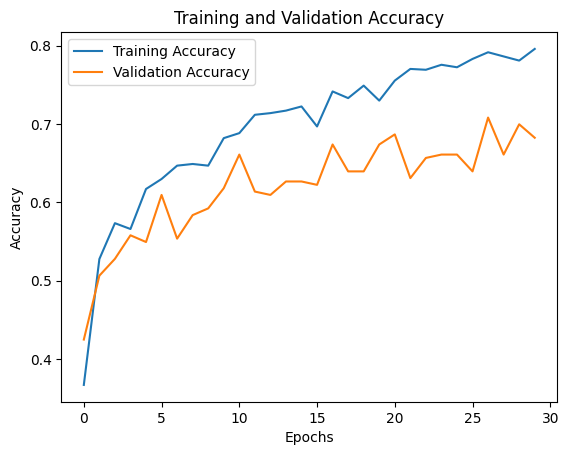

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [12]:
# Load the saved model
model_path = '/content/drive/MyDrive/Colab Notebooks/face_recognition_vgg16_model_augmented.h5'

try:
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()


Model loaded successfully!


Class Names: {0: 'Akshay Kumar', 1: 'Amitabh Bachchan', 2: 'Prabhas', 3: 'vijay'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


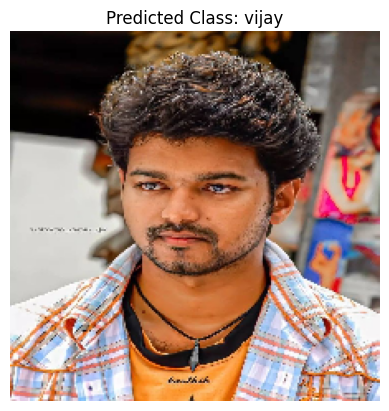

Predicted Class: vijay


In [14]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Automatically map class indices
class_names = train_generator.class_indices
class_names = {v: k for k, v in class_names.items()}  # Reverse dictionary for prediction
print("Class Names:", class_names)

# Function to preprocess and predict an image
def predict_image(img_path):
    """
    Preprocess and predict the class of a given image.
    Args:
    - img_path (str): Path to the image file.

    Returns:
    - Predicted class name.
    """
    try:
        # Load the image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalize pixel values

        # Make predictions
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions[0])
        predicted_class_name = class_names[predicted_class_index]

        # Display the image with the predicted class
        plt.imshow(img)
        plt.title(f"Predicted Class: {predicted_class_name}")
        plt.axis('off')
        plt.show()

        return predicted_class_name

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

# Example usage
img_path = '/content/drive/MyDrive/My dataset/vijay/00085d610ab5d02faf9a32625b460689 (1).jpg'
predicted_class = predict_image(img_path)
if predicted_class:
    print(f"Predicted Class: {predicted_class}")
else:
    print("Prediction failed.")
